In [651]:
import sys
import os

global_data_path = 'C:/Users/jaulab/Desktop/AAD/Data'
global_path = 'C:/Users/jaulab/Desktop/deepAAD_project'
# global_data_path = 'D:/AAD_EEG/Data'

# Include parent dir
SCRIPT_DIR = os.path.dirname(os.path.abspath('play.ipynb'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

In [652]:
import numpy as np
import torch
# Definición funciones para trabajar simpre en float32 con numpy y pytorch
def to_numpy(tensor):
    return tensor.detach().cpu().numpy().astype(np.float32)
def to_tensor(array):
    return torch.tensor(array, dtype=torch.float32)

## GRADIENT SAVING

### GRADIENT CONFORMER COMPUTATION

In [52]:
from models.eeg_conformer import Conformer, ConformerConfig

In [53]:
mdl = Conformer(ConformerConfig)

Number of parameters: 0.41M


In [54]:
mdl.apply(mdl.init_weights)

c:\Users\jaulab\Desktop\deepAAD_project\models\eeg_conformer.py:271: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight, mode= 'fan_out', nonlinearity='relu')


Conformer(
  (embed): PatchEmbedding(
    (shallownet): ModuleList(
      (0): Conv2d(1, 40, kernel_size=(1, 8), stride=(1, 1))
      (1): Conv2d(40, 40, kernel_size=(64, 1), stride=(1, 1))
      (2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ELU(alpha=1.0)
      (4): AvgPool2d(kernel_size=(1, 20), stride=(1, 4), padding=0)
      (5): Dropout(p=0.4, inplace=False)
    )
    (projection): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (encoder): TransformerEncoder(
    (0): EncoderBlock(
      (ln_1): LayerNorm()
      (attn): TemporalSelfAttention(
        (w_q): Linear(in_features=40, out_features=40, bias=True)
        (w_k): Linear(in_features=40, out_features=40, bias=True)
        (w_v): Linear(in_features=40, out_features=40, bias=True)
        (c_proj): Linear(in_features=40, out_features=40, bias=True)
        (attn_dropout): Dropout(p=0.4, inplace=False)
        (resid_dropout): Dropout(p=0.4, inplace=False)
      )
   

In [55]:
x = torch.randn((64, 64, 128))
target = torch.randn(64)
logits, loss = mdl(x, target)
logits.shape, loss

(torch.Size([64]), tensor(0.0422, grad_fn=<NegBackward0>))

In [56]:
loss.backward()

In [57]:
for name, param in mdl.named_parameters():
    if param is not None:
        print(f'Layer {name}: {param.grad}')

Layer embed.shallownet.0.weight: tensor([[[[-1.1589e-01, -1.5722e-01, -1.4105e-01, -1.7125e-01, -1.8921e-01,
           -1.4967e-01, -2.0296e-01, -2.3040e-01]]],


        [[[-8.7813e-02, -7.5573e-02, -8.4988e-02, -4.3029e-02, -2.5184e-02,
           -1.1964e-02, -5.2214e-02, -4.5621e-02]]],


        [[[ 1.7741e-02,  1.9373e-02,  4.6946e-02,  5.7790e-02,  7.1441e-02,
            1.4077e-01,  9.1989e-02,  1.0884e-01]]],


        [[[ 9.3034e-02,  7.0245e-02, -3.6819e-05,  4.3412e-03,  9.4979e-02,
            1.1864e-01,  6.5652e-02,  1.2992e-01]]],


        [[[-1.6778e-01, -1.4607e-01, -1.6653e-01, -3.4871e-02,  3.6625e-02,
            7.3078e-02,  7.1132e-02,  4.2567e-02]]],


        [[[-4.3703e-02, -1.1809e-01, -3.7278e-02, -1.0814e-01, -3.8427e-02,
           -7.2157e-02, -4.8850e-02, -8.6604e-02]]],


        [[[ 1.5178e-02,  3.9372e-02, -3.1354e-02, -1.9728e-02,  9.2279e-02,
           -3.2841e-03,  3.6951e-02, -5.6273e-02]]],


        [[[-3.9252e-02, -4.3034e-02, -2.0035e-02, 

In [58]:
from torch.utils.tensorboard import SummaryWriter

In [59]:
writer = SummaryWriter()

In [60]:
for name, param in mdl.named_parameters():
    if param is not None:
        # SAVING NAME, GRAD, EPOCH
        writer.add_histogram(f'{name}.grad', param.grad, 1)

### WANDB GRADIENT SAVING

In [61]:
import wandb

In [62]:
wandb.init(project='gradient_tracking')

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,0


In [46]:
for name, param in mdl.named_parameters():
    if param.grad is not None and 'bias' not in name:
        # detach that eliminates property of the tensor of requiring grad
        wandb.log({f"{name}_grad": wandb.Histogram(param.cpu().detach().numpy()), "epoch": 0}) 

In [47]:
for name, param in mdl.named_parameters():
    if param.grad is not None and 'bias' not in name:
        print(name)

embed.shallownet.0.weight
embed.shallownet.1.weight
embed.shallownet.2.weight
embed.projection.weight
encoder.0.ln_1.weight
encoder.0.attn.w_q.weight
encoder.0.attn.w_k.weight
encoder.0.attn.w_v.weight
encoder.0.attn.c_proj.weight
encoder.0.ln_2.weight
encoder.0.mlp.c_fc.weight
encoder.0.mlp.c_proj.weight
encoder.1.ln_1.weight
encoder.1.attn.w_q.weight
encoder.1.attn.w_k.weight
encoder.1.attn.w_v.weight
encoder.1.attn.c_proj.weight
encoder.1.ln_2.weight
encoder.1.mlp.c_fc.weight
encoder.1.mlp.c_proj.weight
classif.fc.0.weight
classif.fc.3.weight
classif.fc.6.weight


In [49]:
desired_layers = ['classif.fc.0.weight', 
                  'classif.fc.6.weight', 
                  'embed.shallownet.0.weight',
                  'embed.shallownet.2.weight',
                  'encoder.0.attn.w_q.weight',
                  'encoder.3.attn.w_q.weight',
                  'encoder.0.mlp.c_fc.weight',
                  'encoder.3.mlp.c_fc.weight',
                ]

In [50]:
for name, param in mdl.named_parameters():
    if param.grad is not None and name in desired_layers:
        # detach that eliminates property of the tensor of requiring grad
        wandb.log({f"{name}_grad": wandb.Histogram(param.cpu().detach().numpy()), "epoch": 0}) 

### WANDB WATCH

In [4]:
from utils.datasets import CustomDataset
from utils.functional import get_data_path
from torch.utils.data import DataLoader

In [5]:
data_path = get_data_path('C:/Users/jaulab/Desktop/AAD/Data', 'fulsang', filt=False)
dataset = CustomDataset('fulsang', data_path, 'train', 'S1', 128, 1)

In [6]:
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
mdl.to(device)
optimizer = torch.optim.Adam(mdl.parameters(), lr=1e-06, weight_decay = 1e-04)

NameError: name 'mdl' is not defined

In [88]:
import tqdm

In [91]:
wandb.init(project='gradient_tracking')
wandb.watch(models = mdl, log='all', log_freq=len(data_loader))

max_epoch = 5

for epoch in range(max_epoch):

    tqdm_loader = tqdm.tqdm(data_loader, desc=f'Epoch: {epoch}', leave = False, mininterval=0.5)
    
    epoch_losses = []

    for batch_idx, data in enumerate(tqdm_loader):

        eeg = data['eeg'].to(device, dtype=torch.float)
        stima = data['stima'].to(device, dtype=torch.float)

        preds, loss = mdl(eeg, targets = stima)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss)

    print(f'loss: {torch.mean(loss).item()}')
    wandb.log({'train_loss': -torch.mean(loss).item()})

loss: -0.10746944695711136


loss: -0.03581579402089119


loss: 0.10303233563899994


loss: -0.17529068887233734


loss: 0.03303400054574013


loss: -0.12475737184286118


loss: -0.01291625201702118


KeyboardInterrupt: 

In [4]:
from models.dnn import FCNN, CNN

In [10]:
mdl = FCNN(n_hidden=3)

In [6]:
mdl = CNN()

In [11]:
for layer, param in mdl.named_parameters():
    print(layer)

model.1.weight
model.1.bias
model.4.weight
model.4.bias
model.7.weight
model.7.bias
model.10.weight
model.10.bias


In [9]:
x = torch.randn((64,64,50))
preds, loss = mdl(x)
preds.shape, loss

(torch.Size([64]), None)

### REPRODUCIBILITY DATALOADER

In [16]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [17]:
x = torch.arange(40).view(-1, 1)
x.shape

torch.Size([40, 1])

In [18]:
dataset = TensorDataset(x)
dataloader = DataLoader(dataset, num_workers=2, shuffle=True, batch_size = 10)

In [19]:
torch.manual_seed(2809)
for data in dataloader:
    print(data)

[tensor([[28],
        [ 8],
        [18],
        [14],
        [ 0],
        [22],
        [13],
        [ 5],
        [15],
        [ 3]])]
[tensor([[30],
        [32],
        [39],
        [25],
        [16],
        [34],
        [ 9],
        [ 6],
        [38],
        [29]])]
[tensor([[10],
        [ 7],
        [17],
        [ 2],
        [12],
        [ 1],
        [37],
        [36],
        [31],
        [11]])]
[tensor([[26],
        [19],
        [21],
        [ 4],
        [35],
        [23],
        [27],
        [20],
        [33],
        [24]])]


In [22]:
torch.manual_seed(2809)
for data in dataloader:
    print(data, len(data))

[tensor([[28],
        [ 8],
        [18],
        [14],
        [ 0],
        [22],
        [13],
        [ 5],
        [15],
        [ 3]])] 1
[tensor([[30],
        [32],
        [39],
        [25],
        [16],
        [34],
        [ 9],
        [ 6],
        [38],
        [29]])] 1
[tensor([[10],
        [ 7],
        [17],
        [ 2],
        [12],
        [ 1],
        [37],
        [36],
        [31],
        [11]])] 1
[tensor([[26],
        [19],
        [21],
        [ 4],
        [35],
        [23],
        [27],
        [20],
        [33],
        [24]])] 1


## DATA VISUALIZATION

In [672]:
SCRIPT_DIR

'c:\\Users\\jaulab\\Desktop\\deepAAD_project\\notebooks'

In [673]:
import mne
import numpy as np
from utils.datasets import CustomDataset
from utils.functional import get_data_path
import scipy
import os
import torch
global_path = 'C:/users/jaulab/Desktop'
import matplotlib.pyplot as plt

In [674]:
%matplotlib widget

### EEG MNE VISUALIZATION

In [675]:
# Leer datos npy
data_path = get_data_path(os.path.join(global_path, 'AAD', 'Data'), 'fulsang')
dataset = CustomDataset('fulsang', data_path, 'train', 'S1', window=128, hop=8)

In [676]:
# Leer datos mat
data_path = get_data_path(os.path.join(global_path, 'AAD', 'Data'), 'fulsang')
dataset = CustomDataset('fulsang', data_path, 'train', 'S1', window=128, hop=8, data_type = 'mat')

In [677]:
# Leer datos directamente DATA_preproc.mat
from utils.functional import normalize_eeg
preproc_data = scipy.io.loadmat(os.path.join(data_path ,'S1_data_preproc.mat'))
eeg_data = np.transpose(preproc_data['data']['eeg'][0,0][0,0])[:64, :]
stima_data = np.squeeze(preproc_data['data']['wavA'][0,0][0,0])
eeg_data = normalize_eeg(torch.tensor(eeg_data))

In [678]:
eeg_data = dataset.eeg
eeg_data.shape

torch.Size([64, 153600])

In [679]:
# Nombre canales
subj = 'S1'
eeg_path = os.path.join(global_path, 'AAD', 'Fulsang', 'EEG')
data = scipy.io.loadmat(os.path.join(eeg_path, subj+'.mat'))
channel_names = data['data'][0,0]['dim'][0,0]['chan'][0,0]['eeg'][0,0]
channel_names = [chan[0].item() for chan in channel_names][:64]
channel_names[:5]

['Fp1', 'AF7', 'AF3', 'F1', 'F3']

In [680]:
channel_types = ['eeg'] * eeg_data.shape[0]

In [681]:
fs = 64
# fs = 125
eeg_info = mne.create_info(channel_names, sfreq=fs, ch_types=channel_types)
raw = mne.io.RawArray(eeg_data, eeg_info)
raw.info

Creating RawArray with float64 data, n_channels=64, n_times=153600
    Range : 0 ... 153599 =      0.000 ...  2399.984 secs
Ready.


<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 32.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 64.0 Hz
>

In [21]:
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 32.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 64.0 Hz
>

Effective window size : 32.000 (s)
Plotting power spectral density (dB=True).


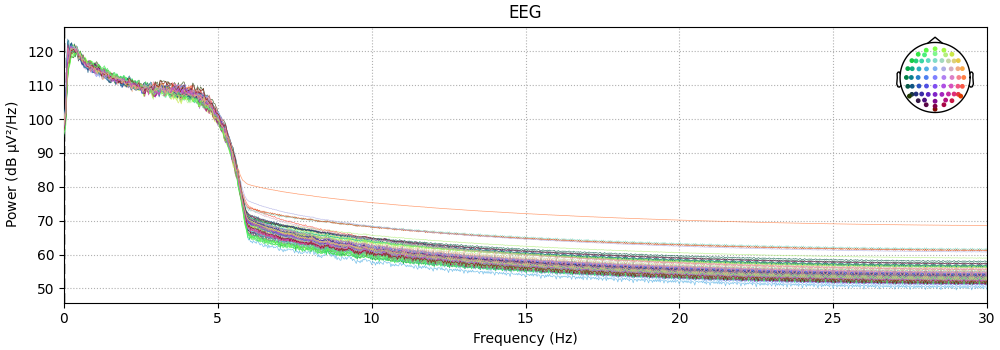

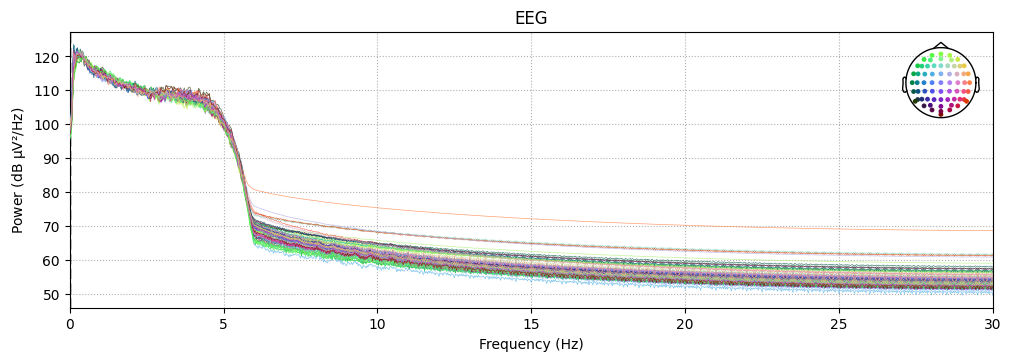

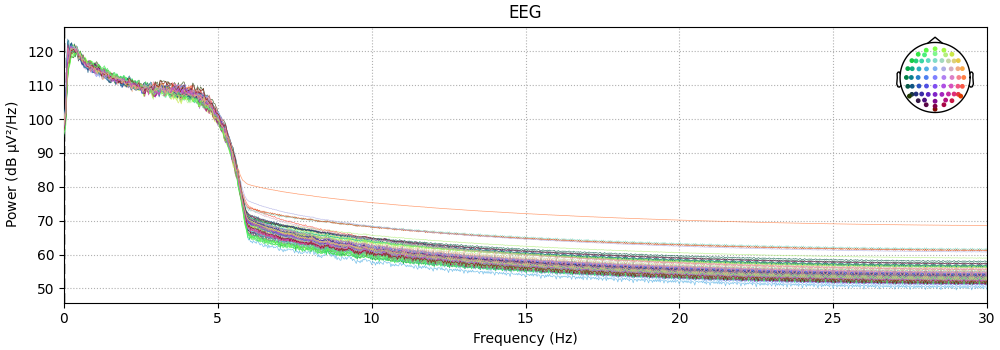

In [22]:
raw.compute_psd(fmax=30).plot(picks="data", exclude="bads", amplitude=False)

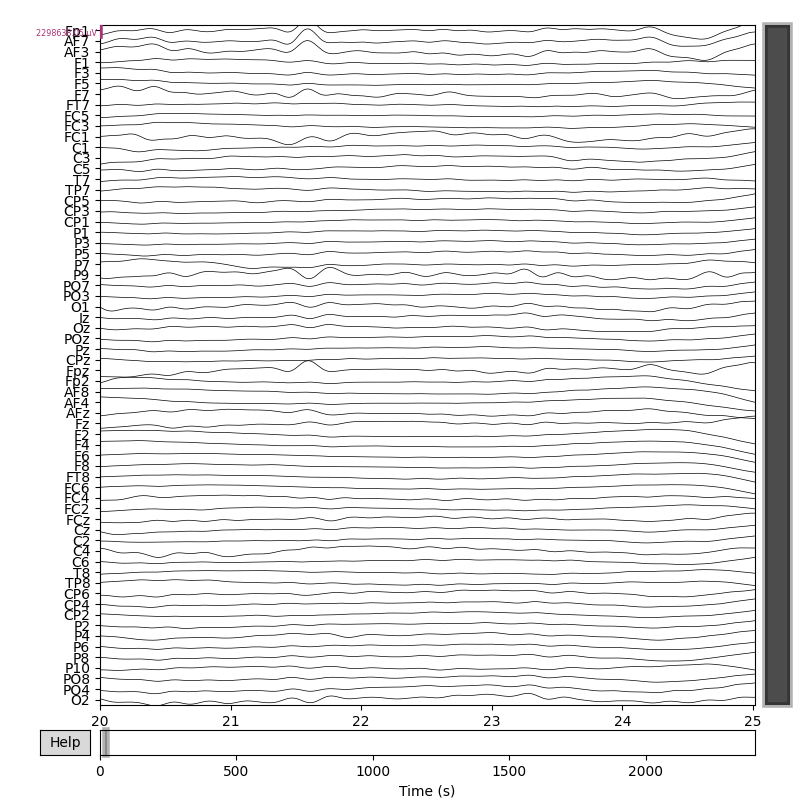

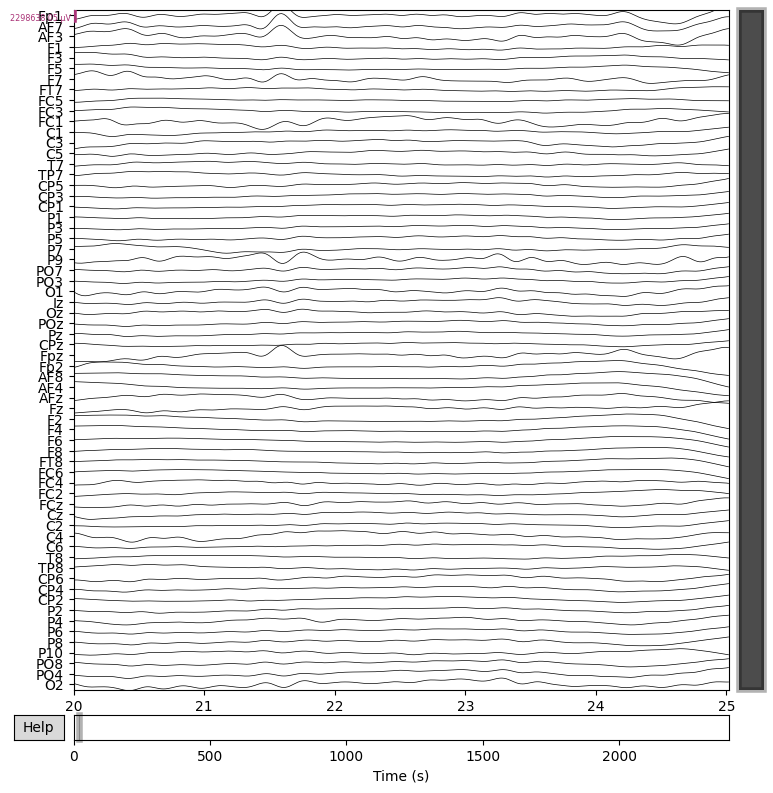

In [23]:
total_duration = raw.times[-1]
start_time = total_duration - 5
raw.plot(start = 20, duration=5, n_channels=64, scalings='auto')

In [38]:
# Aplicar filtrado con la ventana de Hamming
raw.filter(l_freq=0.5, h_freq=8, fir_design='firwin', fir_window='hamming')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawArray | 64 x 300000 (2400.0 s), ~146.6 MB, data loaded>

### STIM VISULAIZATION

In [682]:
envelope = dataset.stima
envelope.shape

torch.Size([1, 153600])

In [683]:
envelope = stima_data

In [684]:
envelope[:64]  

array([ 0.00053309, -0.00110269,  0.00564936,  0.01871718,  0.01431248,
        0.01876585,  0.01662826,  0.01946833,  0.03817216,  0.04088281,
        0.04002726,  0.0434864 ,  0.03985877,  0.04269113,  0.03961981,
        0.04030421,  0.03949867,  0.04000035,  0.03979776,  0.04125089,
        0.03928741,  0.0386541 ,  0.03561674,  0.03656775,  0.03518008,
        0.0348848 ,  0.03464345,  0.03281922,  0.03254671,  0.0308901 ,
        0.0290706 ,  0.02952873,  0.02883402,  0.02866443,  0.02775759,
        0.02836354,  0.02723084,  0.02647014,  0.0270448 ,  0.02741588,
        0.02669665,  0.02716017,  0.0248791 ,  0.02402202,  0.02520036,
        0.02544626,  0.02382061,  0.0247835 ,  0.02361698,  0.02351119,
        0.02220297,  0.02308723,  0.02418303,  0.02418178,  0.02393421,
        0.02313036,  0.02369594,  0.02276023,  0.0227465 ,  0.02510675,
        0.02744117,  0.02927675,  0.03054375,  0.04548538])

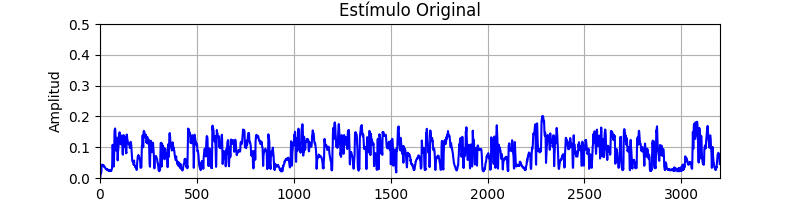

In [685]:
# Representar envolvente derecha
plt.figure(figsize=(8, 2))
plt.plot(envelope, color='Blue')
plt.title('Estímulo Original')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.xlim([0, 50*64])
plt.ylim([0, 0.5])
plt.grid()
plt.show()

### HRTF VISUALIZATION

In [686]:
x = torch.randn((2, 3200))
x = torch.squeeze(x)
x.shape

torch.Size([2, 3200])

In [687]:
global_data_path

'C:/Users/jaulab/Desktop/AAD/Data'

In [688]:
os.path.exists(os.path.join(global_data_path, 'Fulsang_2017', 'HRTFs', subj+'_hrtfs.mat'))

True

In [689]:
subj = 'S1'
hrtf_path = os.path.join(global_data_path, 'Fulsang_2017', 'HRTFs', subj+'_hrtfs.mat')
data = scipy.io.loadmat(hrtf_path)

In [690]:
att_wav = data['wavs'][:,0][0]['wavB'][0,0]
att_wav.shape

(3200, 2)

In [691]:
data_path = get_data_path(global_data_path, 'fulsang')
subj = 'S1'
trials = range(0,60)
preproc_data = scipy.io.loadmat(os.path.join(data_path ,subj + '_data_preproc.mat'))
stima_data = preproc_data['data']['wavA'][0,0][0,trials]
stima_data[0].shape

(3200, 1)

In [692]:
att_wav = data['wavs'][:,0][0]['wavB'][0,0]
att_wav.shape

(3200, 2)

In [693]:
# Load from the Custom dataset
dataset ='fulsang'
data_path = get_data_path(global_data_path, dataset)
train_set = CustomDataset('fulsang', data_path, 'train', 'S5', window=128, hop=8, hrtf=True)

In [694]:
att_wav = train_set.stima.T
att_wav.shape

torch.Size([153600, 2])

In [695]:
# First trial
trial_range = range(0,32000) # trial 1
# trial_range = range(3200, 6400) # trial 2
# trial_range = range(3072, 4800) # trial switch

env_L = att_wav[trial_range,0]
env_R = att_wav[trial_range,1]
env_L.shape, env_R.shape

(torch.Size([32000]), torch.Size([32000]))

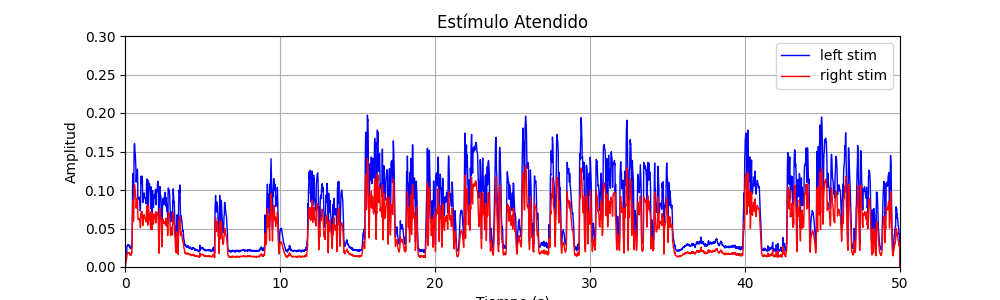

In [696]:
# Representar envolvente derecha
x = np.arange(0, len(env_L)) / 64
plt.figure(figsize=(10, 3))
plt.plot(x, env_L, color='blue', linewidth=1, label='left stim')
plt.plot(x, env_R, color='red', linewidth=1, label='right stim')
# plt.axvline(x=2, color='grey', linestyle='--', linewidth=2, label='trial switch')
plt.title('Estímulo Atendido')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim([0, 50])
plt.ylim([0, 0.3])
plt.grid()
plt.legend()
plt.show()

En la gráfica se observa el cambio de posición de la fuente atendida reflejada en el cambio de dominancia en la señal a partir de los 25s al haber escogido 2 trials distintos.

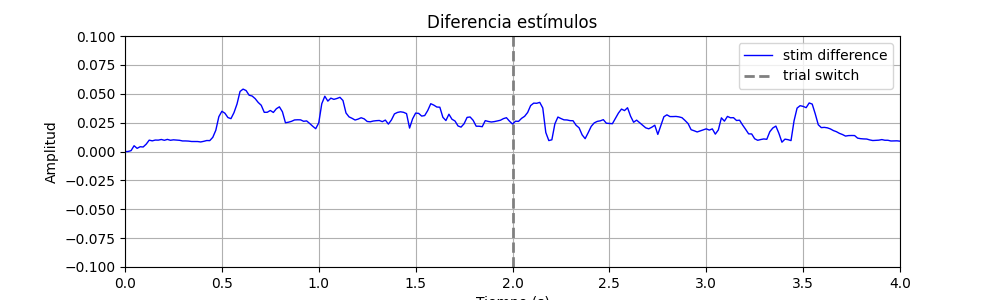

tensor(0.0243, dtype=torch.float64) tensor(0.0008, dtype=torch.float64)


In [699]:
# Representar envolvente derecha
x = np.arange(0, len(env_L)) / 64
plt.figure(figsize=(10, 3))
plt.plot(x, env_L - env_R, color='blue', linewidth=1, label='stim difference')
# plt.plot(x, env_R, color='red', linewidth=1, label='right stim')
plt.axvline(x=2, color='grey', linestyle='--', linewidth=2, label='trial switch')
plt.title('Diferencia estímulos')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim([0, 4])
plt.ylim([-0.1, 0.1])
plt.grid()
plt.legend()
plt.show()
print(torch.mean(torch.abs(env_L - env_R)), torch.mean((env_L - env_R)**2))

### ITD, ILD and more

In [659]:
from scipy.signal import correlate

El *Interaulral time difference* cuantifica el delay entre los dos canales introducidos y resulta crucial para el sonido en baja frecuencia (longitud de onda baja).

In [660]:
def compute_itd(left_channel, right_channel, fs):
    # Compute the cross-correlation to extract the optimal lag
    correlation = correlate(left_channel, right_channel, mode='full')
    lag = np.argmax(correlation) - (len(right_channel) - 1)
    itd = lag / fs
    return itd

In [661]:
# Escenario donde prioriza el estímulo izquierdo
samples = np.arange(0, 3200)
env_L = att_wav[samples,0]
env_R = att_wav[samples,1]
env_L.shape, env_R.shape

(torch.Size([3200]), torch.Size([3200]))

In [662]:
# Computing the cross correlation between signals
correlation = correlate(env_L, env_R, mode='full')
correlation.shape

(6399,)

In [663]:
# The optimal lag it's equal to the maximun corr idx
lag = np.argmax(correlation) - (len(env_R) - 1)
lag

0

Como se observa el instante ideal para el deplazamiento es de 0 muestras. El haber **reducido la frecuencia de muestreo** durante el preprocesado, no permite evaluar este deplazamiento temporal entre señales (**falta de resolución temporal**). Experimentos muestran como esta diferencia entre tiempos de llegada en las señales, en concreto a una **distancia de 22-23cm**, era máxima a los **660us** cuando se colocaba la fuente directamente a 90º azimutalmente. Este delay se corresponde con la frecuencia de **1500Hz** mucho mayor que la que es capaz de discernir nuestro sistema a 64Hz.<br>
Esto implica que tengamos que utilizar una frecuencia de muestreo para la generación del estímulo muy superior a la utilizada y que recoja como mínimo estas diferencias en frecuencias de 1500 Hz para detectar la diferencia de tiempos interaural. El aumentar esta frecuencia de muestreo afecta directamente al planteamiento del modelo, que si predice muestra a muestra como en el caso Fulsang, tendría que aumentar en consecuencia la frecuencia de la señal cerebral para basar las predicciones en una ventana razonable de muestras. Esto variaría todo el comportamiento del modelo si se pretende utilizar el mismo número de muestras y si mantenemos su tamaño o su escala temporal el tamaño del modelo amumentaría proporcionalmente. Esto hace que parezca dificil aumentar la resolución temporal aumentando la fs. <br>
Otra opción que puede resultar útil es la de introducir interpolación en la señal para aunmentar el número de muestras en consecuencia y poder discernir el ITD. <br>

El **interaulral level difference** (ILD) cuantifica la diferencia de nivel entre un canal y otro y resulta crucial para localizar sonidos de alta frecuencia. Esta métrica se calcula realizando los decibelios del cociente de potencias RMS de cada canal.

In [664]:
def compute_ild(left_channel, right_channel):
    # Calculate RMS for each channel
    rms_left = np.sqrt(np.mean(left_channel**2))
    rms_right = np.sqrt(np.mean(right_channel**2))
    # Calculate ILD in dB
    ild = 10 * np.log10(rms_left / rms_right)
    return ild

In [665]:
# Computar la potencia RMS
rms_left = torch.sqrt(torch.mean(env_L**2))
rms_right = torch.sqrt(torch.mean(env_R**2))
rms_left, rms_right

(tensor(0.0839, dtype=torch.float64), tensor(0.0568, dtype=torch.float64))

In [666]:
# Computar los decibelios
ild = 10 * np.log10(rms_left / rms_right)
ild

tensor(1.6942, dtype=torch.float64)

Esta métrica a difencia de la ITD si que resulta discernible en el escenario actual. Ya se aprecia la diferencia de amplitudes en la gráfica pero esta métrica permite cuantificar este fenómeno en la ventana temporal que selccionemos. Esta información puede ser de gran ayuda para nuestro sistema ya que permite extraer la información espacial, en el caso de la base de datos Fulsang +60º -60º, con facilidad. <br>
Ahora queda por comprobar que métodología es la adecuada a la hora de introducir esta información en el modelo donde se plantean varias opciones:
- Introducir el valor dentro de la función de pérdida como regularizador
- Finetunear la red para que se ajuste a este valor
- Realizar una red paralela que obtenga este valor y por tanto se base en la detección de la espacialización del audio.

In [668]:
# Channel difference
diff_mae = torch.mean(torch.abs((env_L - env_R) - (env_R - env_L)))
diff_mse = torch.mean(((env_L - env_R) - (env_R - env_L))**2)
diff_mse, diff_mae

(tensor(0.0030, dtype=torch.float64), tensor(0.0467, dtype=torch.float64))

## TORCH STACK VS TORCH VIEW

### TORCH VIEW

In [83]:
import torch

In [93]:
eeg = torch.randn((48, 64, 3200))
stima = torch.randn((48, 3200))
eeg.shape, stima.shape

(torch.Size([48, 64, 3200]), torch.Size([48, 3200]))

In [95]:
eeg[0,0,:20]

tensor([ 0.9058, -0.7303, -0.7819, -0.0534,  0.9283, -1.1002,  0.0673,  1.3093,
         2.2213, -1.5466,  0.6059, -0.0122, -0.8739,  1.1717, -0.7180,  0.3788,
        -0.0058, -1.3935, -0.3751,  1.2459])

In [96]:
stima[0,:20]

tensor([ 0.3259, -0.8756,  0.2687,  0.3264, -0.0306,  0.1277,  0.2319, -0.9652,
        -1.1888, -0.1164,  1.1225, -1.7293,  0.0452,  0.4111, -0.0043, -0.9332,
        -1.0006,  0.3696,  0.8481, -1.4191])

In [97]:
eeg_cat = eeg.view(eeg.shape[1], eeg.shape[0] * eeg.shape[2])
stima_cat = stima.view(-1)
eeg_cat.shape, stima_cat.shape

(torch.Size([64, 153600]), torch.Size([153600]))

In [98]:
eeg[0, :20]

tensor([ 0.9058, -0.7303, -0.7819, -0.0534,  0.9283, -1.1002,  0.0673,  1.3093,
         2.2213, -1.5466,  0.6059, -0.0122, -0.8739,  1.1717, -0.7180,  0.3788,
        -0.0058, -1.3935, -0.3751,  1.2459])

In [99]:
stima[:20]

tensor([ 0.3259, -0.8756,  0.2687,  0.3264, -0.0306,  0.1277,  0.2319, -0.9652,
        -1.1888, -0.1164,  1.1225, -1.7293,  0.0452,  0.4111, -0.0043, -0.9332,
        -1.0006,  0.3696,  0.8481, -1.4191])

### Bug loading data on dataset.py
En el dataset cuando se carga el eeg o el estímulo en fulsang, el modelo es capaz de entrenar correctamente sólo si se carga tanto eeg como estímulo utilizando la carga tradicional. Si se carga utilizando funciones .view de pytorch, el modelo deja de entrenarse correctamente. ¿A que se debe, es un fallo del tipo de datos o existe una diferencia en la concatención de datos cuando se utiliza hstack respecto de stack y luego view?

In [77]:
# Generate data
n_trials = 48
np.random.seed(1)
eeg_data = [np.random.randn(3200, 64) for n in range(n_trials)]
stima_data = [np.random.randn(3200, 1) for n in range(n_trials)]
eeg_data[0].shape, len(eeg_data), eeg_data[0].dtype, eeg_data[0][:5, 0]

((3200, 64),
 48,
 dtype('float64'),
 array([ 1.62434536,  0.48851815, -1.19926803,  1.90465871,  2.05117344]))

In [91]:
# Stack + view
eeg_data_cat = torch.stack([normalize_eeg(torch.tensor(eeg_data[trial]).T) for trial in range(n_trials)], dim=0)
eeg_data_cat = eeg_data_cat.view(eeg_data_cat.shape[1], eeg_data_cat.shape[0] * eeg_data_cat.shape[2])
eeg_data_cat.shape, eeg_data_cat[0,:5]

(torch.Size([64, 153600]),
 tensor([ 1.6896,  0.5250, -1.2055,  1.9770,  2.1272], dtype=torch.float64))

In [90]:
# Hstack
eeg_data_cat = torch.hstack([normalize_eeg(torch.tensor(eeg_data[trial]).T) for trial in range(n_trials)])
eeg_data_cat.shape, eeg_data_cat[0,:5]

(torch.Size([64, 153600]),
 tensor([ 1.6896,  0.5250, -1.2055,  1.9770,  2.1272], dtype=torch.float64))

In [89]:
# Stack + view
stima_data_cat = torch.squeeze(torch.tensor(np.stack(stima_data)))
stima_data_cat = stima_data_cat.view(-1)
stima_data_cat.shape, stima_data_cat[:5]

(torch.Size([153600]),
 tensor([-2.2720, -1.8724,  0.2086, -0.3089,  0.8754], dtype=torch.float64))

In [88]:
# Vstack
stima_data_cat = torch.squeeze(torch.vstack([torch.tensor(stima_data[trial]) for trial in range(n_trials)]))
stima_data_cat[:5], stima_data_cat.shape

(tensor([-2.2720, -1.8724,  0.2086, -0.3089,  0.8754], dtype=torch.float64),
 torch.Size([153600]))

El fallo en la simulación ocurre con el ajuste de datos de eeg cuando se realiza stack + view en vez de hstack aunque como se ha comprobado no tiene por que existir diferencia entre ambos métodos

## Ridge and CCA: sckit_learn functions

### Ridge CV function
Esta función realiza una regresión lineal utilizando la regularización l2 (alpha) e implementando una validación cruzada que si no se especifica resulta en una validación leave-one-out. La idea es compar el Ridge original del código con la función de scikit learn que incluye una validación cruzada para un modelo subject-specific con una 5-fold cv.

In [82]:
from utils.datasets import CustomDataset
from utils.functional import get_data_path
from models.ridge import Ridge
from sklearn.linear_model import RidgeCV
import torch
from scipy.linalg import toeplitz
from tqdm import tqdm

In [3]:
subject = 'S2'
dataset = 'fulsang'

In [4]:
# Carga de datos
window = 320
data_path = get_data_path(global_data_path, dataset)
train_set = CustomDataset(dataset, data_path, 'train', subject, 3200, 3200, unit_output=False)
val_set = CustomDataset(dataset, data_path, 'val', subject, 3200, 3200, unit_output=False)
test_set = CustomDataset(dataset, data_path, 'test', subject, window, window, unit_output=False)
train_set.eeg.shape, val_set.eeg.shape, test_set.eeg.shape, train_set.stima.shape, val_set.stima.shape, test_set.stima.shape

(torch.Size([64, 153600]),
 torch.Size([64, 19200]),
 torch.Size([64, 19200]),
 torch.Size([153600]),
 torch.Size([19200]),
 torch.Size([19200]))

In [5]:
alphas = np.logspace(-2, 10, 13)
alphas

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])

In [219]:
# New lagged function: Introduce a matrix of shape (C, T) and return a matrix (L*C, T)
def get_lagged_matrix(X, start_lag, end_lag):
    n_chan, n_times = X.shape
    n_lags = end_lag - start_lag
    lagged_matrix = np.zeros((n_chan * n_lags, n_times))
    if start_lag < 0:
        range = np.arange(end_lag, start_lag, -1)
    else:
        range = np.arange(start_lag, end_lag)

    for i, lag in enumerate(range):
        
        shifted_X = np.roll(X, shift=lag, axis=1)

        # Rellenamos los elementos desplazados con ceros según el signo de lag
        if lag > 0:
            shifted_X[:, :lag] = 0  # Zerofill beginning if lag > 0
        elif lag < 0:
            shifted_X[:, lag:] = 0  # Zerofill end if lag < 0

        # Insertamos el canal desplazado en su posición en la matriz lageada
        lagged_matrix[i * n_chan:(i + 1) * n_chan, :] = shifted_X

    return lagged_matrix

### Ridge original

In [6]:
# Cargo el modelo original
mdl = Ridge(start_lag=-25, end_lag=0, alpha = alphas)

In [7]:
# Train the model
mdl.fit(train_set.eeg.T, train_set.stima[:, np.newaxis])

Checking inputs...


Computing lagged matrix: 100%|██████████| 48/48 [00:02<00:00, 23.69it/s]


Computing autocorr_matrix...
Calculating coefficients...


Itenrating through alphas: 13it [00:01,  6.77it/s]


In [8]:
# Decoder shape with (alphas, output_feat, input_feat, time_lags)
# To predict the stim, this coefs are selected by each alpha and out dim, then they're 
# flattened to (T*L, 1) vector
mdl.coef_.shape 

(13, 1, 64, 25)

In [9]:
# Validate the model and select best alpha
scores = mdl.model_selection(val_set.eeg.T, val_set.stima[:, np.newaxis])
best_alpha = mdl.best_alpha_idx
print(f'Ridge trained for {dataset} data with a score of {scores[best_alpha]} with alpha = {best_alpha}')

Ridge trained for fulsang data with a score of 0.16519777872052394 with alpha = 4


In [10]:
len(test_set), test_set[0]['eeg'].shape

(59, torch.Size([64, 320]))

In [11]:
# Evaluate the model for each trial
att_corr = 0
scores_att = []
scores_unatt = []
for n, trial in enumerate(test_set):
    score_a = mdl.score(trial['eeg'].T, trial['stima'][:, np.newaxis])
    score_b = mdl.score(trial['eeg'].T, trial['stimb'][:, np.newaxis])
    if score_a > score_b: att_corr += 1
    scores_att.append(score_a), scores_unatt.append(score_b)
    if n >= len(test_set): break

print(f'Dec accuracy: {(att_corr / len(scores_att)) * 100} | corr mean: {np.mean(score_a)}')

Dec accuracy: 63.33333333333333 | corr mean: 0.3661702265384934


### Ridge sklearn

In [85]:
# for cross validating cat the train and val data
train_cv_set_eeg = torch.hstack((train_set.eeg, val_set.eeg))
train_cv_set_stima = torch.cat((train_set.stima, val_set.stima))
train_cv_set_stimb = torch.cat((train_set.stimb, val_set.stimb))
train_cv_set_eeg.shape, train_cv_set_stima.shape

(torch.Size([64, 172800]), torch.Size([172800]))

In [86]:
# Importar las métricas
from scipy.stats import pearsonr
from sklearn.metrics import make_scorer

In [32]:
x, y = torch.randn(3200), torch.randn(3200)
pearson_corr(x, y)

-0.03759372242314142

In [87]:
def pearson_corr(y_true, y_pred):
    return pearsonr(y_true, y_pred).statistic

pearson_scorer = make_scorer(pearson_corr, greater_is_better=True)

In [88]:
# implement scikit_learn function with a 7-fold validation
model = RidgeCV(alphas, cv=7, scoring='neg_mean_squared_error')

In [13]:
train_cv_set_eeg.shape

NameError: name 'train_cv_set_eeg' is not defined

In [61]:
sim_eeg = np.random.randn(64,3200)
lag = get_lagged_matrix(sim_eeg, -25, 0)

In [66]:
lag.shape, lag[3][-10:]

((1600, 3200),
 array([-1.03526134, -0.72736798,  1.14598611,  1.09334456,  1.12925306,
         0.32337409,  0.68136466,  0.        ,  0.        ,  0.        ]))

In [123]:
# Parameters
start_lag = -25
end_lag = 0
n_chan, n_times = train_cv_set_eeg.size()
trial_len = 3200
n_trials = n_times // trial_len

In [125]:
for n in tqdm(range(n_trials), desc="Computing lagged matrix"):
    start = n * trial_len
    end = start + trial_len
    lagged_matrix = get_lagged_matrix(train_cv_set_eeg, -25, 0)
    # for ipf in range(input_feat):
    #     lagged_matrix[start:end, :, ipf] = get_lagged_matrix(X[start:end, ipf], start_lag, end_lag)
lagged_matrix.shape

Computing lagged matrix: 100%|██████████| 54/54 [01:09<00:00,  1.28s/it]


(1600, 172800)

In [126]:
lagged_matrix = np.transpose(lagged_matrix)
lagged_matrix.shape

(172800, 1600)

In [127]:
model.fit(lagged_matrix, train_cv_set_stima)

RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
        cv=7, scoring='neg_mean_squared_error')

In [128]:
model.alpha_

10000000.0

In [129]:
model.coef_.shape

(1600,)

In [133]:
start_lag, end_lag

(-25, 0)

In [134]:
# Evaluate the model for each trial
att_corr = 0
scores_att = []
scores_unatt = []
for n, trial in enumerate(test_set):
    # Compute the lagged matrix
    X = trial['eeg']
    # input_feat, n_times = X.size()
    lagged_trial = get_lagged_matrix(X, start_lag, end_lag)
    lagged_trial = np.transpose(lagged_trial)
    # lagged_trial = np.zeros((n_times, num_lags, input_feat))
    # for ipf in range(input_feat):
    #     lagged_trial[:, :, ipf] = get_lagged_matrix(X[:, ipf], start_lag, end_lag)
    # lagged_trial = np.reshape(lagged_trial, (n_times, num_lags*input_feat))
    print(trial['eeg'].shape, trial['stima'].shape, lagged_trial.shape)
    # score_a = model.score(lagged_trial, trial['stima'])
    # score_b = model.score(lagged_trial, trial['stimb'])
    score_a = pearson_corr(model.predict(lagged_trial), trial['stima'])
    score_b = pearson_corr(model.predict(lagged_trial), trial['stimb'])
    if score_a > score_b: att_corr += 1
    scores_att.append(score_a), scores_unatt.append(score_a)
    if n >= len(test_set): break
print(f'Dec accuracy: {(att_corr / len(scores_att)) * 100} | corr mean: {np.mean(score_a)}')

torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([

In [67]:
# Diagonal + alpha como en skl con cholesky
A = np.zeros((16, 16))
A.flat[::16+1] += 1

In [68]:
import matplotlib.pyplot as plt

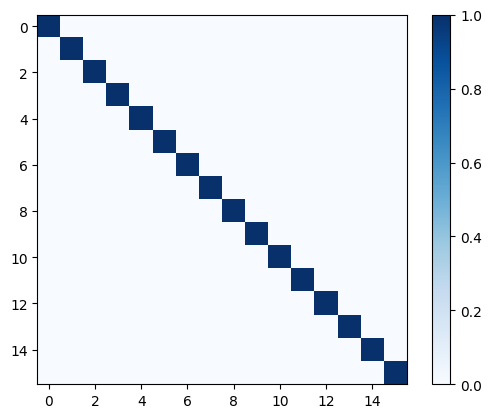

In [69]:
plt.imshow(A, cmap='Blues')
plt.colorbar()
plt.show()

## Canonical correlation analysis CCA
El método CCA que extrae dados una serie (trial) de EEG (3200x64) y de estímulo (3200x1) los vectores de pesos W1 (64, J) y W2 (1, J) que transforman los datos para que esten correlados al máximo posible. <br> 
Lo hacemos con una descomposición de vectores y valores propios de la matriz: XX(t) * XY * YY(t) * XX para el caso eeg siendo una matriz que resulta en 64x64 en el caso donde no se incluye lag. <br>
El valor propio máximo marca la correlación entre las dos fuentes de datos (EEG y estímulo). Queda por probar el valor de J el cual define el sub espacio en el que se proyectan los datos y que debe ser el mínimo de entre la dimensión de la envelope que viene dada por el delay y la longitud del encoder (1.25 segundos).
Para clasificar estos componentes se puede utilizar un clasificador LDA con la proyección de los datos que máximice la precisión del clasificador.

In [4]:
from utils.datasets import CustomDataset
from utils.functional import get_data_path
from scipy.linalg import toeplitz
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
subject = 'S2'
# subject = ['S'+str(n) for n in range(1, 9)]
dataset = 'fulsang'

In [8]:
# Carga de datos
window = 3200
data_path = get_data_path(global_data_path, dataset)
train_set = CustomDataset(dataset, data_path, 'train', subject, 3200, 3200, unit_output=False)
val_set = CustomDataset(dataset, data_path, 'val', subject, window, window, unit_output=False)
test_set = CustomDataset(dataset, data_path, 'test', subject, window, window, unit_output=False)
train_set.eeg.shape, val_set.eeg.shape, test_set.eeg.shape, train_set.stima.shape, val_set.stima.shape, test_set.stima.shape

(torch.Size([64, 153600]),
 torch.Size([64, 19200]),
 torch.Size([64, 19200]),
 torch.Size([153600]),
 torch.Size([19200]),
 torch.Size([19200]))

In [9]:
# New lagged function: Introduce a matrix of shape (C, T) and return a matrix (L*C, T)
def get_lagged_matrix(X, start_lag, end_lag):
    n_chan, n_times = X.shape
    n_lags = end_lag - start_lag
    lagged_matrix = np.zeros((n_chan * n_lags, n_times))
    # if start_lag < 0:
    #     range = np.arange(end_lag, start_lag, -1)
    # else:
    #     range = np.arange(start_lag, end_lag)
    range = np.arange(start_lag, end_lag)
    
    for i, lag in enumerate(range):
        
        shifted_X = np.roll(X, shift=lag, axis=1)

        # Rellenamos los elementos desplazados con ceros según el signo de lag
        if lag > 0:
            shifted_X[:, :lag] = 0  # Zerofill beginning if lag > 0
        elif lag < 0:
            shifted_X[:, lag:] = 0  # Zerofill end if lag < 0

        # Insertamos el canal desplazado en su posición en la matriz lageada
        lagged_matrix[i * n_chan:(i + 1) * n_chan, :] = shifted_X

    return lagged_matrix

### CCA implícito

In [69]:
# Conjunto de datos
train_set.eeg.shape, train_set.eeg.dtype, train_set.stima.shape, train_set.stima.dtype, val_set.eeg.shape, val_set.eeg.dtype, val_set.stima.shape, val_set.stima.dtype 

(torch.Size([64, 153600]),
 torch.float64,
 torch.Size([153600]),
 torch.float64,
 torch.Size([64, 19200]),
 torch.float64,
 torch.Size([19200]),
 torch.float64)

In [70]:
# Compute both lagged matrix
n_chan, n_times = train_set.eeg.shape
trial_len = 3200
n_trial = n_times // trial_len
lagged_eeg = np.zeros((n_chan*16, n_times))
lagged_stim = np.zeros((80, n_times))
for trial in range(n_trial):
    start = trial * trial_len
    end = (trial+1) * trial_len
    lagged_eeg[:,start:end] = get_lagged_matrix(train_set.eeg[:,start:end], start_lag=-16, end_lag=0) # 250 ms of post-stimulus lags on eeg decoder
    lagged_stim[:, start:end] = get_lagged_matrix(train_set.stima[np.newaxis,start:end], start_lag=0, end_lag=80) # 1.25s of post-stimulus lags on eeg decoder

In [71]:
lagged_eeg.shape, lagged_stim.shape

((1024, 153600), (80, 153600))

In [72]:
lagged_eeg[4,-10:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

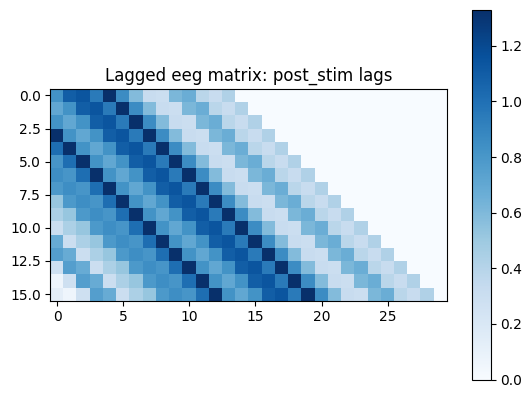

In [73]:
plt.imshow(lagged_eeg[::64][:,-30:], cmap='Blues')
plt.colorbar()
plt.title('Lagged eeg matrix: post_stim lags')
plt.show()

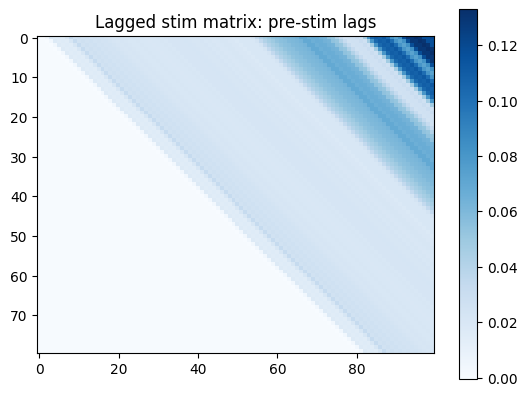

In [74]:
plt.imshow(lagged_stim[:,:100], cmap='Blues')
plt.colorbar()
plt.title('Lagged stim matrix: pre-stim lags')
plt.show()

In [76]:
# Estandarización de los datos
lagged_eeg = (lagged_eeg - lagged_eeg.mean(axis=1, keepdims=True)) / lagged_eeg.std(axis=1, keepdims=True)
lagged_stim = (lagged_stim - lagged_stim.mean(axis=1, keepdims=True)) / lagged_stim.std(axis=1, keepdims=True)

In [77]:
# Compute covariance matrices and
XtX = np.dot(lagged_eeg, lagged_eeg.T)
YtY = np.dot(lagged_stim, lagged_stim.T)
XtY = np.dot(lagged_eeg, lagged_stim.T)
YtX = np.dot(lagged_stim, lagged_eeg.T)

In [78]:
XtX.shape, YtY.shape, XtY.shape, YtX.shape

((1024, 1024), (80, 80), (1024, 80), (80, 1024))

In [86]:
from numpy.linalg import inv
from numpy.linalg import eigh
from numpy.linalg import svd
from scipy.stats import pearsonr

#### SVD

In [80]:
# Usar la descomposición de valores singulares (SVD) para encontrar combinaciones lineales
# Valores y vectores propios de la matriz 
eig_vals_X, eig_vecs_X = eigh(XtX)
eig_vals_Y, eig_vecs_Y = eigh(YtY)

In [83]:
# Valores para normalizar y transformar la matriz XtY
S_inv_X = np.dot(eig_vecs_X, np.diag(1.0/np.sqrt(eig_vals_X)))
S_inv_Y = np.dot(eig_vecs_Y, np.diag(1.0/np.sqrt(eig_vals_Y)))
T = np.dot(np.dot(S_inv_X.T, XtY), S_inv_Y)

In [84]:
T.shape

(1024, 80)

In [94]:
U, s, Vt = svd(T)

In [95]:
U.shape, Vt.shape, s.shape

((1024, 1024), (80, 80), (80,))

In [96]:
# Descomponer T para la obtención de los vectores conónicos
J = 16
Wx = U[:, :J]
Wy = Vt[:, :J]

### Eigen decomposition

In [18]:
# Compute the squared canonical correlation matrix for the decoder X
X_SCC = np.dot(inv(XtX), XtY)
print(X_SCC.shape)
X_SCC = np.dot(X_SCC, inv(YtY))
print(X_SCC.shape)
X_SCC = np.dot(X_SCC, YtX)
X_SCC.shape

(1024, 80)
(1024, 80)


(1024, 1024)

In [19]:
# Compute the squared canonical correlation matrix for the encoder Y
Y_SCC = np.dot(inv(YtY), YtX)
print(Y_SCC.shape)
Y_SCC = np.dot(Y_SCC, inv(XtX))
print(Y_SCC.shape)
Y_SCC = np.dot(Y_SCC, XtY)
Y_SCC.shape

(80, 1024)
(80, 1024)


(80, 80)

In [20]:
# Extract the eigenvalues and eigenvectors of the canonical components matrices
S_X, V_X = eigh(X_SCC)
S_Y, V_Y = eigh(Y_SCC)
S_X.shape, V_X.shape, S_Y.shape, V_Y.shape

((1024,), (1024, 1024), (80,), (80, 80))

In [21]:
S_X[:10], S_Y[:10]

(array([-0.08764653, -0.0635588 , -0.02539225, -0.01843899, -0.01487047,
        -0.01358073, -0.01169637, -0.01094975, -0.00960482, -0.00884115]),
 array([-1.34498674e-02, -4.00485731e-04, -2.66351055e-05,  5.38438384e-05,
         9.69617577e-05,  1.28258779e-04,  1.60628016e-04,  1.69680184e-04,
         1.77857340e-04,  1.89932695e-04]))

In [22]:
# Sort the eigenvalues and corresponding eigenvectors
sX_idx = np.argsort(S_X)[::-1]
S_X = S_X[sX_idx]
sY_idx = np.argsort(S_Y)[::-1]
S_Y = S_Y[sY_idx]
S_X[:10], S_Y[:10]

(array([0.10350435, 0.08178057, 0.02908198, 0.02103364, 0.0160712 ,
        0.01514486, 0.01321612, 0.01189521, 0.01016671, 0.00850166]),
 array([0.02755606, 0.0159283 , 0.0066203 , 0.00412747, 0.00323487,
        0.00279761, 0.00203325, 0.00168466, 0.00135067, 0.00122752]))

In [23]:
# Select the J correlation coefficients and validate their correlation
J = 16
Wx = V_X[:, :J]
Wy = V_Y[:, :J]
Wy.shape, Wx.shape

((80, 16), (1024, 16))

### Applying weights

In [97]:
# Validate coefficients showing correlation
n_trials = len(train_set)
scores_a = np.zeros((n_trials, J))
scores_b = np.zeros((n_trials, J))

for n, trial in enumerate(train_set):

    if n >= len(train_set): break
    
    # Compute the lagged matrix
    eeg = trial['eeg']
    stima = trial['stima']
    stimb = trial['stimb']

    lagged_eeg = get_lagged_matrix(eeg, -16, 0)
    lagged_stima = get_lagged_matrix(stima[np.newaxis, :], 0, 80)
    lagged_stimb = get_lagged_matrix(stimb[np.newaxis, :], 0, 80)
    # print(trial['eeg'].shape, trial['stima'].shape, lagged_eeg.shape, lagged_stima.shape)

    eeg_proj = np.dot(Wx.T, lagged_eeg)
    stima_proj = np.dot(Wy.T, lagged_stima)
    stimb_proj = np.dot(Wy.T, lagged_stimb)

    scores_a[n, :] = np.array([pearsonr(eeg_proj[j], stima_proj[j])[0] for j in range(J)])
    scores_b[n, :] = np.array([pearsonr(eeg_proj[j], stimb_proj[j])[0] for j in range(J)])

    scores_a[n, :] = np.array([pearsonr(eeg_proj[j], stima_proj[j])[0] - pearsonr(eeg_proj[j], stimb_proj[j])[0] for j in range(J)])
    scores_b[n, :] = np.array([pearsonr(eeg_proj[j], stimb_proj[j])[0] - pearsonr(eeg_proj[j], stima_proj[j])[0] for j in range(J)])
    
    # score_a = [pearsonr(eeg_proj[j], stima_proj[j])[0] for j in range(J)]
    # uncorr_a = [pearsonr(eeg_proj[j], eeg_proj[j+1])[0] for j in range(J-1)]
    # score_b = [pearsonr(eeg_proj[j], stimb_proj[j])[0] for j in range(J)]
    # f = [corr_a - corr_b for corr_a, corr_b in zip(score_a, score_b)]

    # # Observe the correlation
    # print([f'{score:.3f}' for score in score_a])
    # print([f'{score:.3f}' for score in uncorr_a])
    # print([f'{score:.3f}' for score in score_b])
    # print([f'{score:.3f}' for score in f])
    # att_correct = 0
    # for corr_a, corr_b in zip(score_a, score_b):
    #     if corr_a > corr_b: att_correct += 1
    # print(att_correct)
    
    
# print(f'Dec accuracy: {(att_corr / len(scores_att)) * 100} | corr mean: {np.mean(score_a)}')

In [98]:
scores_a.shape, scores_b.shape

((47, 16), (47, 16))

Hasta aquí hemos proyectado tanto el EEG como el estímulo, en un sub-espacio J donde las señales estan correladas entre sí. Una vez obtenemos estos vectores de correlación, entrenamos un linear discriminant classifier (LDA) para clasificar estas correlaciones entre señal attendida y no atendida. 

In [99]:
# Definición LDA: a la entrada tenemos una serie de correlaciones resultantes de la proyección CCA
# de dimensión (n_smaples, n_feat). El clasificador supervisado se entrena con la correlaciones atendidas (y=1)
# y con las no atendidas (y=0).

def lda_fit(X, y):

    class_labels = np.unique(y) # etiquetas de cada clase (0:no atendida y 1:atendida)
    mean_overall = np.mean(X, axis=0)

    # Scatter/matriz de dispersión dentro de las clases: mide la dispersión de datos dentro de la clase
    # Cabe esperar un valor elevado ya que la varianza dentro de las clases es elevada
    S_W = np.zeros((X.shape[1], X.shape[1]))
    # Scatter/matriz de dispersión entre clases: mide como las medias de distintas clases están separadas entre sí
    # Cabe esperar un valor bajo ya que las distribuciones de correlación atendida y no atendida obtienen valores similares por lo tanto medias similares
    S_B = np.zeros((X.shape[1], X.shape[1]))

    # Calcular las matrices de dispersión
    for label in class_labels:
        X_c = X[y == label] # subconjunto de la clase actual
        mean_c = np.mean(X_c, axis=0)
        S_W += np.dot((X_c - mean_c).T, (X_c - mean_c)) # Suma dentro de las clases
        n_c = X_c.shape[0]
        mean_diff = (mean_c - mean_overall).reshape(-1,1)
        S_B += n_c * np.dot(mean_diff, mean_diff.T) # Suma entre clases

    # Resolver el problema de valores propios para la matriz S_W^(-1) * S_B
    eig_vals, eig_vect = eigh(np.dot(inv(S_W), S_B))

    sorted_indices = np.argsort(eig_vals)[::-1]
    eig_vecs = eig_vect[:, sorted_indices]

    # Seleccionar los primeros vectores (dimensionalidad <= n_clases - 1)
    # En este caso seleccionar el primero y único
    W = eig_vecs[:, 1] # Proyección espacio LDA para proyectar correlaciones en las clases (J, 1)

    return W

def lda_transform(X, W):
     return np.dot(X, W)

In [100]:
scores = np.vstack((scores_a, scores_b))
labels = np.concatenate((np.ones(scores_a.shape[0]), np.zeros(scores_b.shape[0])))
scores[47], scores_b[0], labels[:5], labels[-5:], labels.shape, scores.shape

(array([-1.83281010e-02, -5.14455479e-03,  3.01482857e-06,  2.78738589e-02,
         4.70152052e-02, -3.74374243e-02, -1.30711856e-02,  1.12117280e-01,
        -4.92272231e-02, -2.89083218e-02, -9.74279745e-02,  6.06021215e-02,
         3.80176497e-02, -6.24727228e-03,  1.89738148e-02, -1.57336079e-01]),
 array([-1.83281010e-02, -5.14455479e-03,  3.01482857e-06,  2.78738589e-02,
         4.70152052e-02, -3.74374243e-02, -1.30711856e-02,  1.12117280e-01,
        -4.92272231e-02, -2.89083218e-02, -9.74279745e-02,  6.06021215e-02,
         3.80176497e-02, -6.24727228e-03,  1.89738148e-02, -1.57336079e-01]),
 array([1., 1., 1., 1., 1.]),
 array([0., 0., 0., 0., 0.]),
 (94,),
 (94, 16))

In [101]:
LDA = lda_fit(scores, labels)
LDA.shape

(16,)

In [102]:
# Hallar el umbral basado en la media de clases
scores_projected = lda_transform(scores, LDA)
mean_att = scores_projected[labels == 1].mean()
mean_unatt = scores_projected[labels == 0].mean()
threshold = (mean_att + mean_unatt) / 2
mean_att, mean_unatt, threshold

(0.010431377380980628, -0.010431377380980628, 0.0)

In [104]:
# Validate the model
att_corr = 0
unatt_corr = 0
for n, trial in enumerate(val_set):

    if n >= len(val_set): break
    
    # Compute the lagged matrix
    eeg = trial['eeg']
    stima = trial['stima']
    stimb = trial['stimb']

    lagged_eeg = get_lagged_matrix(eeg, -16, 0)
    lagged_stima = get_lagged_matrix(stima[np.newaxis, :], 0, 80)
    lagged_stimb = get_lagged_matrix(stimb[np.newaxis, :], 0, 80)
    # print(trial['eeg'].shape, trial['stima'].shape, lagged_eeg.shape, lagged_stima.shape)

    eeg_proj = np.dot(Wx.T, lagged_eeg)
    stima_proj = np.dot(Wy.T, lagged_stima)
    stimb_proj = np.dot(Wy.T, lagged_stimb)

    scores_att = np.array([pearsonr(eeg_proj[j], stima_proj[j])[0] for j in range(J)])
    scores_unatt = np.array([pearsonr(eeg_proj[j], stimb_proj[j])[0] for j in range(J)])

    # if lda_transform(scores_att, LDA) > threshold: att_corr +=1
    # if lda_transform(scores_unatt, LDA) < threshold: unatt_corr +=1
    if lda_transform(scores_att, LDA) > lda_transform(scores_unatt, LDA): att_corr +=1

print(f'Dec Att: {att_corr / len(val_set) * 100} | Dec Unatt: {unatt_corr / len(val_set) * 100}')

Dec Att: 60.0 | Dec Unatt: 0.0


### CCA sklearn

In [34]:
from sklearn.cross_decomposition import CCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import pearsonr

In [19]:
# Compute both lagged matrix
n_chan, n_times = train_set.eeg.shape
trial_len = 3200
n_trial = n_times // trial_len
lagged_eeg = np.zeros((n_chan*16, n_times))
lagged_stim = np.zeros((80, n_times))
for trial in range(n_trial):
    start = trial * trial_len
    end = (trial+1) * trial_len
    lagged_eeg[:,start:end] = get_lagged_matrix(train_set.eeg[:,start:end], start_lag=-16, end_lag=0) # 250 ms of post-stimulus lags on eeg decoder
    lagged_stim[:, start:end] = get_lagged_matrix(train_set.stima[np.newaxis,start:end], start_lag=0, end_lag=80) # 1.25s of post-stimulus lags on eeg decoder

In [20]:
lagged_eeg.shape, lagged_stim.shape

((1024, 153600), (80, 153600))

In [21]:
model = CCA(n_components=16)

In [22]:
model.fit(lagged_eeg.T, lagged_stim.T)

CCA(n_components=16)

In [64]:
# Validate coefficients showing correlation
J = 16
n_trials = len(train_set)
scores_a = np.zeros((n_trials, J))
scores_b = np.zeros((n_trials, J))

for n, trial in enumerate(train_set):

    if n >= len(train_set): break
    
    # Compute the lagged matrix
    eeg = trial['eeg']
    stima = trial['stima']
    stimb = trial['stimb']

    lagged_eeg = get_lagged_matrix(eeg, -16, 0)
    lagged_stima = get_lagged_matrix(stima[np.newaxis, :], 0, 80)
    lagged_stimb = get_lagged_matrix(stimb[np.newaxis, :], 0, 80)
    # print(trial['eeg'].shape, trial['stima'].shape, lagged_eeg.shape, lagged_stima.shape)

    # eeg_proj = np.dot(Wx.T, lagged_eeg)
    # stima_proj = np.dot(Wy.T, lagged_stima)
    # stimb_proj = np.dot(Wy.T, lagged_stimb)
    eeg_proj, stima_proj  = model.transform(lagged_eeg.T, lagged_stima.T)
    eeg_proj, stimb_proj  = model.transform(lagged_eeg.T, lagged_stimb.T)

    eeg_proj, stima_proj, stimb_proj = eeg_proj.T, stima_proj.T, stimb_proj.T

    # scores_a[n, :] = np.array([pearsonr(eeg_proj[j], stima_proj[j])[0] for j in range(J)])
    # scores_b[n, :] = np.array([pearsonr(eeg_proj[j], stimb_proj[j])[0] for j in range(J)])

    # scores_a[n, :] = np.array([pearsonr(eeg_proj[j], stima_proj[j])[0] - pearsonr(eeg_proj[j], stimb_proj[j])[0] for j in range(J)])
    # scores_b[n, :] = np.array([pearsonr(eeg_proj[j], stimb_proj[j])[0] - pearsonr(eeg_proj[j], stima_proj[j])[0] for j in range(J)])

    score_a = [pearsonr(eeg_proj[j], stima_proj[j])[0] for j in range(J)]
    uncorr_a = [pearsonr(eeg_proj[j], eeg_proj[j+1])[0] for j in range(J-1)]
    score_b = [pearsonr(eeg_proj[j], stimb_proj[j])[0] for j in range(J)]
    f = [corr_a - corr_b for corr_a, corr_b in zip(score_a, score_b)]

    # Observe the correlation
    print([f'{score:.3f}' for score in score_a])
    print([f'{score:.3f}' for score in uncorr_a])
    print([f'{score:.3f}' for score in score_b])
    print([f'{score:.3f}' for score in f])
    att_correct = 0
    for corr_a, corr_b in zip(score_a, score_b):
        if corr_a > corr_b: att_correct += 1
    print(att_correct)

['0.266', '0.248', '0.226', '0.102', '0.109', '0.162', '0.128', '0.123', '0.110', '0.083', '0.051', '0.099', '0.063', '0.044', '0.045', '0.048']
['0.025', '-0.095', '0.067', '-0.011', '-0.035', '-0.034', '-0.029', '0.002', '-0.008', '0.005', '-0.000', '0.040', '0.033', '0.011', '-0.026']
['0.060', '0.059', '0.069', '-0.027', '0.010', '0.027', '0.007', '0.004', '-0.006', '0.004', '-0.020', '-0.047', '-0.018', '-0.005', '-0.023', '-0.023']
['0.206', '0.188', '0.157', '0.130', '0.099', '0.135', '0.121', '0.119', '0.116', '0.078', '0.071', '0.146', '0.081', '0.049', '0.068', '0.071']
16
['0.165', '0.185', '0.067', '0.149', '0.109', '0.103', '0.113', '0.063', '0.123', '0.100', '0.092', '0.104', '0.082', '0.081', '0.100', '0.096']
['0.147', '-0.051', '0.017', '0.006', '-0.038', '-0.007', '-0.074', '-0.015', '0.005', '0.031', '0.012', '0.016', '0.016', '0.010', '0.022']
['0.088', '0.146', '0.056', '0.018', '0.025', '0.020', '-0.021', '-0.003', '-0.004', '0.007', '-0.005', '0.006', '-0.038', '

In [39]:
scores = np.vstack((scores_a, scores_b))
labels = np.concatenate((np.ones(scores_a.shape[0]), np.zeros(scores_b.shape[0])))
labels.shape, scores.shape

((94,), (94, 16))

In [40]:
classifier = LinearDiscriminantAnalysis()
classifier.fit(scores, labels)

LinearDiscriminantAnalysis()

In [41]:
# Hallar el umbral basado en la media de clases
scores_projected = classifier.transform(scores)
mean_att = scores_projected[labels == 1].mean()
mean_unatt = scores_projected[labels == 0].mean()
threshold = (mean_att + mean_unatt) / 2
mean_att, mean_unatt, threshold

(4.639983318347451, -4.639983318347451, 0.0)

In [45]:
scores.shape, scores_projected.shape

((94, 16), (94, 1))

In [63]:
# Validate the model
att_corr = 0
unatt_corr = 0
for n, trial in enumerate(val_set):

    if n >= len(val_set): break
    
    # Compute the lagged matrix
    eeg = trial['eeg']
    stima = trial['stima']
    stimb = trial['stimb']

    lagged_eeg = get_lagged_matrix(eeg, -16, 0)
    lagged_stima = get_lagged_matrix(stima[np.newaxis, :], 0, 80)
    lagged_stimb = get_lagged_matrix(stimb[np.newaxis, :], 0, 80)
    # print(trial['eeg'].shape, trial['stima'].shape, lagged_eeg.shape, lagged_stima.shape)

    eeg_proj, stima_proj  = model.transform(lagged_eeg.T, lagged_stima.T)
    eeg_proj, stimb_proj  = model.transform(lagged_eeg.T, lagged_stimb.T)

    eeg_proj, stima_proj, stimb_proj = eeg_proj.T, stima_proj.T, stimb_proj.T

    scores_att = np.array([pearsonr(eeg_proj[j], stima_proj[j])[0] for j in range(J)])
    scores_unatt = np.array([pearsonr(eeg_proj[j], stimb_proj[j])[0] for j in range(J)])

    scores_att = scores_att.reshape(1, -1)
    scores_unatt = scores_unatt.reshape(1, -1)

    # if classifier.transform(scores_att) > threshold: att_corr +=1
    # if classifier.transform(scores_unatt) < threshold: unatt_corr +=1
    if classifier.transform(scores_att) > classifier.transform(scores_unatt): att_corr +=1

print(f'Dec Att: {att_corr / len(val_set) * 100} | Dec Unatt: {unatt_corr / len(val_set) * 100}')

Dec Att: 80.0 | Dec Unatt: 0.0


In [61]:
scores_att

array([[ 0.09729247,  0.09873472, -0.07094762,  0.09867445,  0.11047514,
         0.04335861,  0.05355934,  0.03429573, -0.05641655, -0.07046149,
        -0.03577175, -0.0250085 ,  0.01470592,  0.01040238,  0.02128904,
        -0.00099524]])

In [58]:
array = np.random.randn(16)
array.reshape(1, -1).shape

(1, 16)

## Finetune

In [32]:
from models.dnn import CNN, FCNN
from models.eeg_conformer import Conformer
import torch

In [23]:
mdl = FCNN(3, n_chan=64, n_samples=50)

In [24]:
mdl.model[:-1]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3200, out_features=2400, bias=True)
  (2): Tanh()
  (3): Dropout(p=0.45, inplace=False)
  (4): Linear(in_features=2400, out_features=1600, bias=True)
  (5): Tanh()
  (6): Dropout(p=0.45, inplace=False)
  (7): Linear(in_features=1600, out_features=800, bias=True)
  (8): Tanh()
  (9): Dropout(p=0.45, inplace=False)
)

In [11]:
mdl = CNN()

In [25]:
mdl.finetune()

In [30]:
mdl.model[4]

Linear(in_features=2400, out_features=1600, bias=True)

In [31]:
for param in mdl.model[4].parameters():
    print(param.grad)

None
None


In [26]:
# forward pass
x = torch.randn((64, 64, 50))
target = torch.randn((64, 1))
preds, loss = mdl(x, target)

In [27]:
loss.backward()

In [2]:
import torch

In [33]:
x = torch.randn((128, 2)).T
y = torch.randn((128, 2)).T
(x[0] - x[1]).shape

torch.Size([128])

In [34]:
torch.sum(((x[0] - x[1]) - (y[0] - y[1]))**2) / len((x[0] - x[1]))

tensor(4.1591)

In [35]:
import torch.nn as nn

In [45]:
criterion = nn.L1Loss()
preds = torch.randn((3, 5))
targets = torch.randn((3, 5))
preds, targets

(tensor([[ 0.7890, -0.4720, -0.8914,  0.4164,  1.1530],
         [-0.9381,  0.8940, -0.3024,  2.7361, -0.1491],
         [ 0.0970,  2.5370, -0.6092,  0.8989,  0.3412]]),
 tensor([[-1.8373,  1.0060, -0.8999, -0.3698,  1.5617],
         [ 0.9038,  0.1359, -1.1673,  0.3109, -0.4472],
         [-1.1316, -0.3680,  0.3343, -0.3166, -0.8106]]))

In [46]:
loss = criterion(preds, targets)
loss.shape, loss

(torch.Size([]), tensor(1.2627))

In [51]:
from torch.nn import functional as F
import matplotlib.pyplot as plt

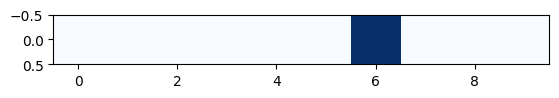

In [60]:
x = F.one_hot(torch.tensor(6), 10)
plt.imshow(x.unsqueeze(0), cmap='Blues')

In [61]:
# Predict all the metrics for fitting the classifier
corr_att = torch.randn((200))
corr_unatt = torch.randn((200))
ild_att = torch.randn((200))
ild_unatt = torch.randn((200))

In [79]:
# Concatenate the scores and generate a label array to feed LDA
corr_train = torch.cat((corr_att, corr_unatt))
ild_train = torch.cat((ild_att, ild_unatt))
metrics = torch.vstack((corr_train, ild_train)).T
labels = torch.cat((torch.ones(200), torch.zeros(200)))

In [80]:
corr_train.shape, ild_train.shape, metrics.shape, labels.shape

(torch.Size([400]), torch.Size([400]), torch.Size([400, 2]), torch.Size([400]))

## Spatial classifier

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from models.dnn import CNN
from utils.loss_functions import CustomLoss
import yaml
model = LinearDiscriminantAnalysis()

In [452]:
config_file = '../configs/spatial_audio/diff_mae_criterion.yaml'

with open(config_file, 'r') as archivo:
    config = yaml.safe_load(archivo)

config

{'global_path': 'C:/Users/jaulab/Desktop/deepAAD_project',
 'global_data_path': 'C:/Users/jaulab/Desktop/AAD/Data',
 'exp_name': 'diff_mae_criterion',
 'runs': [{'model': 'CNN',
   'train_params': {'batch_size': 128,
    'max_epoch': 200,
    'lr': '2e-05',
    'weight_decay': '1e-08',
    'early_stopping_patience': 5,
    'scheduler_patience': 2,
    'loss_mode': 'corr_diff_mae',
    'alpha_loss': 0.1},
   'dataset_params': {'window_len': 50,
    'hop': 1,
    'filt': False,
    'fixed': False,
    'rnd_trials': False,
    'window_pred': False,
    'hrtf': True,
    'shuffle': False},
   'model_params': {'F1': 8,
    'D': 8,
    'F2': 64,
    'AP1': 2,
    'AP2': 4,
    'dropout': 0.2,
    'input_samples': 50,
    'output_dim': 2}},
  {'model': 'CNN',
   'train_params': {'batch_size': 128,
    'max_epoch': 200,
    'lr': '2e-05',
    'weight_decay': '1e-08',
    'early_stopping_patience': 5,
    'scheduler_patience': 2,
    'loss_mode': 'corr_diff_mae',
    'alpha_loss': 0.2},
   'dat

In [453]:
alpha_idx = [n for n, run in enumerate(config['runs']) if run['train_params']['alpha_loss'] == 0.1]

In [454]:
mode = 'mae'
alpha = 0.1

indices = [n for n, run in enumerate(config['runs']) if (run['train_params']['alpha_loss'] == float(alpha)) and (mode in run['train_params']['loss_mode'])]
indices

[0]

In [455]:
key = 'population'
model = 'CNN'
dataset_name, dataset = 'fulsang', 'fulsang'
run = config['runs'][indices[0]]

In [456]:
# Extract the model name and add the extensions to the model name depending on the params
mdl_name = f'{model}_batch={run["train_params"]["batch_size"]}_block={run["dataset_params"]["window_len"]}_lr={run["train_params"]["lr"]}'
loss_mode = run['train_params']['loss_mode']
if loss_mode != 'mean': mdl_name += '_' + loss_mode
if alpha != 0: mdl_name += '_alpha=' + str(alpha)
if run['dataset_params']['hrtf']: mdl_name += '_hrtf'
mdl_name

'CNN_batch=128_block=50_lr=2e-05_corr_diff_mae_alpha=0.1_hrtf'

In [457]:
# Extract the model path
from utils.functional import get_filename, get_channels, get_subjects
project = 'spatial_audio'
finetuned = False
mdl_load_folder = 'finetune_models' if finetuned else 'models'
global_path = config['global_path']

mdl_load_path = os.path.join(global_path, 'results', project, key, mdl_load_folder)
mdl_folder = os.path.join(mdl_load_path, dataset_name+'_data', mdl_name)
if key == 'population' and not finetuned:
    mdl_filename = os.listdir(mdl_folder)[0] # only a single trained model
else:
    mdl_filename = get_filename(mdl_folder, subj) # search for the model related with the subj

In [458]:
# Load the model
run['model_params']['input_channels'] = get_channels(dataset)
mdl = CNN(**run['model_params'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mdl.load_state_dict(torch.load(os.path.join(mdl_folder, mdl_filename), map_location=torch.device(device)))
mdl.to(device)
mdl.eval()

CNN(
  (temporal): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (spatial): Sequential(
    (0): Conv2d(8, 64, kernel_size=(1, 64), stride=(1, 1), groups=8)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0)
    (4): Dropout2d(p=0.2, inplace=False)
  )
  (depthwise): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0)
    (5): Dropout2d(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_fea

In [459]:
# LOSS FUNCTION
criterion = CustomLoss(mode=loss_mode, window_pred=False, alpha_end=alpha)
# CREATE THE CLASSIFIER
spatial_clsf = LinearDiscriminantAnalysis() 

In [ ]:
# LOAD DATA
dataset_params = run['dataset_params']

window_len = dataset_params['window_len'] # Number of samples for context
hop = dataset_params['hop']
hrtf = dataset_params['hrtf']
window_pred = False
subjects = get_subjects(dataset)

train_set = CustomDataset(dataset, data_path, 'train', subjects, window=window_len, hop=hop, window_pred=False, hrtf=hrtf)

In [533]:
# batch_size = run['train_params']['batch_size'] # Window pred size
batch_size = 64
train_loader = DataLoader(train_set, batch_size, shuffle= False, pin_memory=True)

In [534]:
train_set.stima.shape

torch.Size([2, 2764800])

In [535]:
# COLLECT THE PREDICTIONS OF THE MODEL
corr_att = torch.zeros((len(train_loader)))
corr_unatt = torch.zeros((len(train_loader)))
ild_att = torch.zeros((len(train_loader)))
ild_unatt = torch.zeros((len(train_loader)))

with torch.no_grad():
    for batch, data in enumerate(train_loader):
        
        eeg = data['eeg'].to(device, dtype=torch.float)
        stima = data['stima'].to(device, dtype=torch.float)
        stimb = data['stimb'].to(device, dtype=torch.float)
        
        y_hat = mdl(eeg)

        loss_list_att = criterion(preds=y_hat, targets = stima)
        corr_att[batch] = loss_list_att[1]
        ild_att[batch] = loss_list_att[2]

        loss_list_unatt = criterion(preds=y_hat, targets = stimb)
        corr_unatt[batch] = loss_list_unatt[1]
        ild_unatt[batch] = loss_list_unatt[2]

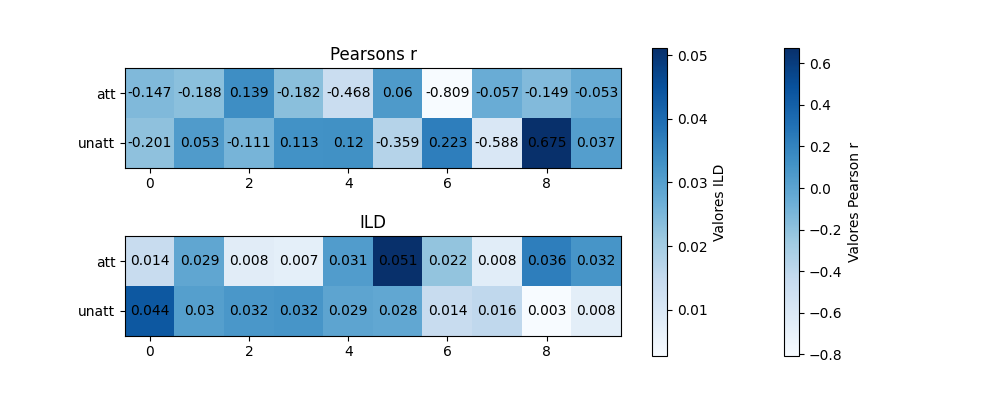

In [570]:
import matplotlib.pyplot as plt

indices = torch.randperm(ild_att.size(0))[:10]

matrix = torch.stack((corr_att[indices], corr_unatt[indices]))

fig, axs = plt.subplots(2, 1, figsize=(10,4))

im = axs[0].imshow(matrix, cmap='Blues')
axs[0].set_yticks(ticks=[0, 1], labels=['att', 'unatt'])
axs[0].set_title('Pearsons r')
# axs[0].set_colorbar(label='Valor')
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        axs[0].text(j, i, round(matrix[i, j].item(), 3), ha='center', va='center')

# Barra de color (opcional)
fig.colorbar(im, ax=axs, label='Valores Pearson r')

matrix = torch.stack((ild_att[indices], ild_unatt[indices]))

im = axs[1].imshow(matrix, cmap='Blues')
axs[1].set_yticks(ticks=[0, 1], labels=['att', 'unatt'])
axs[1].set_title('ILD')
# plt.colorbar(label='Valor')
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        axs[1].text(j, i, round(matrix[i, j].item(), 3), ha='center', va='center')

# Barra de color (opcional)
fig.colorbar(im, ax=axs, label='Valores ILD')

plt.show()

In [571]:
ild_att[:10], ild_unatt[:10]

(tensor([0.0114, 0.0366, 0.0293, 0.0334, 0.0258, 0.0338, 0.0242, 0.0369, 0.0267,
         0.0398]),
 tensor([0.0219, 0.0323, 0.0249, 0.0170, 0.0045, 0.0095, 0.0114, 0.0051, 0.0057,
         0.0233]))

In [587]:
# Concatenate the scores and generate a label array to feed LDA
corr_train = torch.cat((corr_att, corr_unatt))
ild_train = torch.cat((ild_att, ild_unatt))
metrics = torch.stack((corr_train, ild_train)).T
labels = torch.cat((torch.ones(len(train_loader)), torch.zeros(len(train_loader))))

RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated

In [ ]:
# Normalize the metrics
scaler = MinMaxScaler()
norm_metrics = scaler.fit_transform(metrics)

In [574]:
spatial_clsf = LinearDiscriminantAnalysis()
spatial_clsf.fit(norm_metrics, labels)

LinearDiscriminantAnalysis()

In [471]:
# LOAD THE VAL SET SOR EACH SUBJECT
subj = get_subjects(dataset)
# subj = 'S1'
val_set = CustomDataset(dataset, data_path, 'val',  subj, window=window_len, hop=hop, window_pred=False, hrtf=hrtf)

In [575]:
val_batch_size = 64
val_loader = DataLoader(val_set, batch_size = val_batch_size, shuffle= False, pin_memory=True)

In [576]:
# COLLECT THE VALIDATION PREDICTIONS OF THE MODEL
corr_att_list = torch.zeros((len(val_loader)))
corr_unatt_list = torch.zeros((len(val_loader)))
ild_att_list = torch.zeros((len(val_loader)))
ild_unatt_list = torch.zeros((len(val_loader)))

att_correct = 0
with torch.no_grad():
    for batch, data in enumerate(val_loader):
        
        eeg = data['eeg'].to(device, dtype=torch.float)
        stima = data['stima'].to(device, dtype=torch.float)
        stimb = data['stimb'].to(device, dtype=torch.float)
        
        y_hat = mdl(eeg)

        [loss_att, corr_att, ild_att] = criterion(preds=y_hat, targets = stima)
        corr_att_list[batch] = corr_att
        ild_att_list[batch] = ild_att

        [loss_unatt, corr_unatt, ild_unatt] = criterion(preds=y_hat, targets = stimb)
        corr_unatt_list[batch] = corr_unatt
        ild_unatt_list[batch] = ild_unatt
        
        corr_att, corr_unatt, ild_att, ild_unatt = corr_att.cpu(), corr_unatt.cpu(), ild_att.cpu(), ild_unatt.cpu()
        score_a = spatial_clsf.transform(torch.stack((corr_att, ild_att)).unsqueeze(0))
        score_b = spatial_clsf.transform(torch.stack((corr_unatt, ild_att)).unsqueeze(0))

        if score_a >= score_b:
            att_correct += 1

accuracy = att_correct / len(val_loader)
print(f'Accuracy classifying is {accuracy}')

Accuracy classifying is 0.5692592592592592


In [577]:
# Concatenate the scores and generate a label array to feed LDA
corr_val = torch.cat((corr_att_list, corr_unatt_list))
ild_val = torch.cat((ild_att_list, ild_unatt_list))
metrics = torch.stack((corr_val, ild_val)).T
labels = torch.cat((torch.ones(len(val_loader)), torch.zeros(len(val_loader))))

In [578]:
# Normalize metrics
scaler = MinMaxScaler()
norm_metrics = scaler.fit_transform(metrics)

In [579]:
# Proyección de los datos en la dirección discriminante
projected_data = spatial_clsf.transform(norm_metrics)
spatial_clsf.score(norm_metrics, labels)

0.5488888888888889

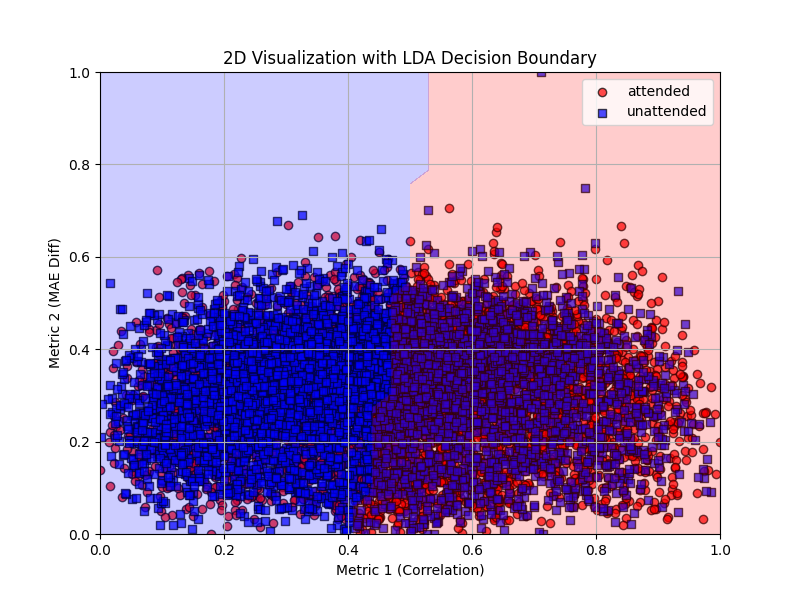

In [602]:
# Gráfico 2D de los datos
plt.figure(figsize=(8, 6))

# Dibujar puntos de cada clase
for label, color, marker, class_label in zip([0, 1], ['red', 'blue'], ['o', 's'], ['attended', 'unattended']):
    plt.scatter(
        norm_metrics[labels == label, 0],  # Métrica 1 (X)
        norm_metrics[labels == label, 1],  # Métrica 2 (Y)
        color=color,
        label=class_label,
        alpha=0.7,
        edgecolor='k',
        marker=marker
    )

# Calcular y graficar la línea de decisión
x_min, x_max = norm_metrics[:, 0].min() - 1, norm_metrics[:, 0].max() + 1
y_min, y_max = norm_metrics[:, 1].min() - 1, norm_metrics[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Predicciones para cada punto del grid
grid = np.c_[xx.ravel(), yy.ravel()]
decision_boundary = spatial_clsf.predict(grid)
decision_boundary = decision_boundary.reshape(xx.shape)

# Contorno de la frontera de decisión
plt.contourf(xx, yy, decision_boundary, levels=[-0.1, 0.5, 1.1], colors=['red', 'blue'], alpha=0.2)

# Etiquetas y ajustes
plt.title('2D Visualization with LDA Decision Boundary')
plt.xlabel('Metric 1 (Correlation)')
plt.ylabel('Metric 2 (MAE Diff)')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.grid(True)
plt.show()

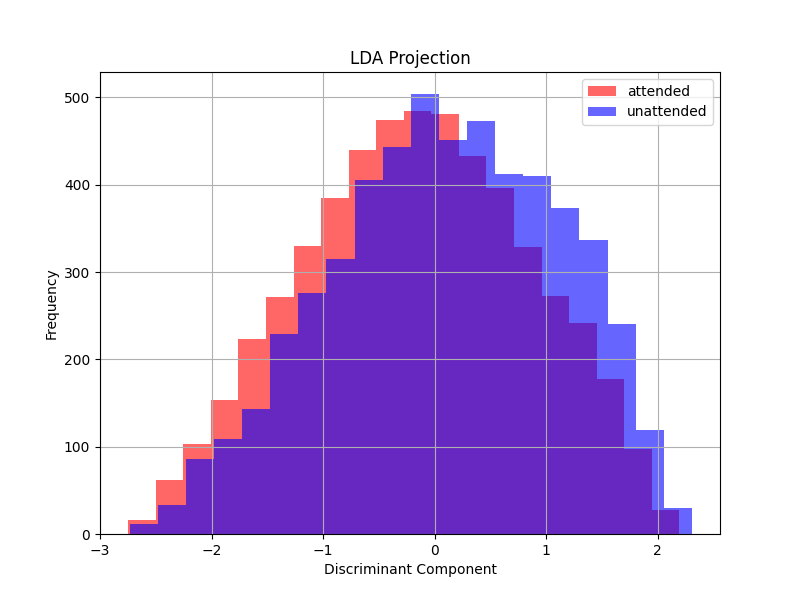

In [581]:
# Visualización de los resultados
plt.figure(figsize=(8, 6))
for label, color, class_label in zip([0, 1], ['red', 'blue'], ['attended', 'unattended']):
    plt.hist(
        projected_data[labels == label],
        bins=20,
        alpha=0.6,
        color=color,
        label=class_label
    )

plt.title('LDA Projection')
plt.xlabel('Discriminant Component')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [582]:
accuracy

0.5692592592592592

In [583]:
metrics.shape, len(val_loader)

(torch.Size([10800, 2]), 5400)

In [588]:
accuracy_att = spatial_clsf.score(norm_metrics[:len(val_loader)], torch.ones((len(val_loader))))
accuracy_att

0.5401851851851852

In [589]:
accuracy_unatt = spatial_clsf.score(norm_metrics[len(val_loader):], torch.zeros((len(val_loader))))
accuracy_unatt

0.5575925925925926

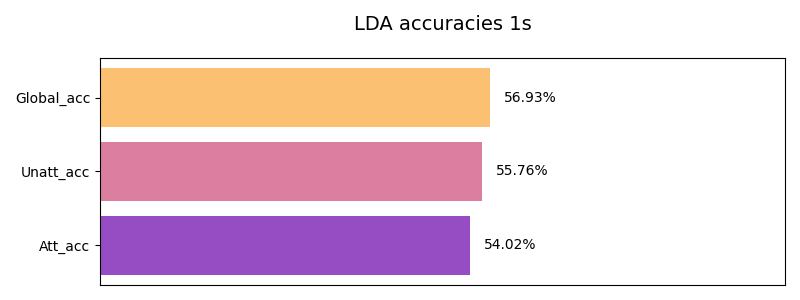

In [596]:
# Crear el gráfico de barras
import  matplotlib.cm as cm
acc_labels = ['Att_acc', 'Unatt_acc', 'Global_acc']
accuracies = [accuracy_att, accuracy_unatt, accuracy]
percentages = [acc * 100 for acc in accuracies]

# Crear una escala de colores en violeta
colors = cm.plasma([0.2, 0.5, 0.8])  # Valores entre 0 y 1 para variar el color en la paleta


plt.figure(figsize=(8,3))
plt.barh(acc_labels, percentages, color= cm.plasma([0.2, 0.5, 0.8]), alpha=0.7)

# Añadir valores encima de cada barra
for i, valor in enumerate(percentages):
    plt.text(valor + 2, i, f'{valor:.2f}%', va='center', fontsize=10)

# Personalización
plt.title(f'LDA accuracies {batch_size // 64}s', fontsize=14, pad=20)
plt.xlabel('(%)', fontsize=12)
plt.xlim(0, 100)  # Escala para porcentajes
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().axes.get_xaxis().set_visible(False)  # Ocultar el eje X
plt.tight_layout()
plt.xlabel('off')
plt.show()

In [598]:
# Crear el gráfico de barras
import  matplotlib.cm as cm
acc_labels = ['Att_acc', 'Unatt_acc', 'Global_acc']
accuracies = [accuracy_att, accuracy_unatt, accuracy]
percentages = [acc * 100 for acc in accuracies]

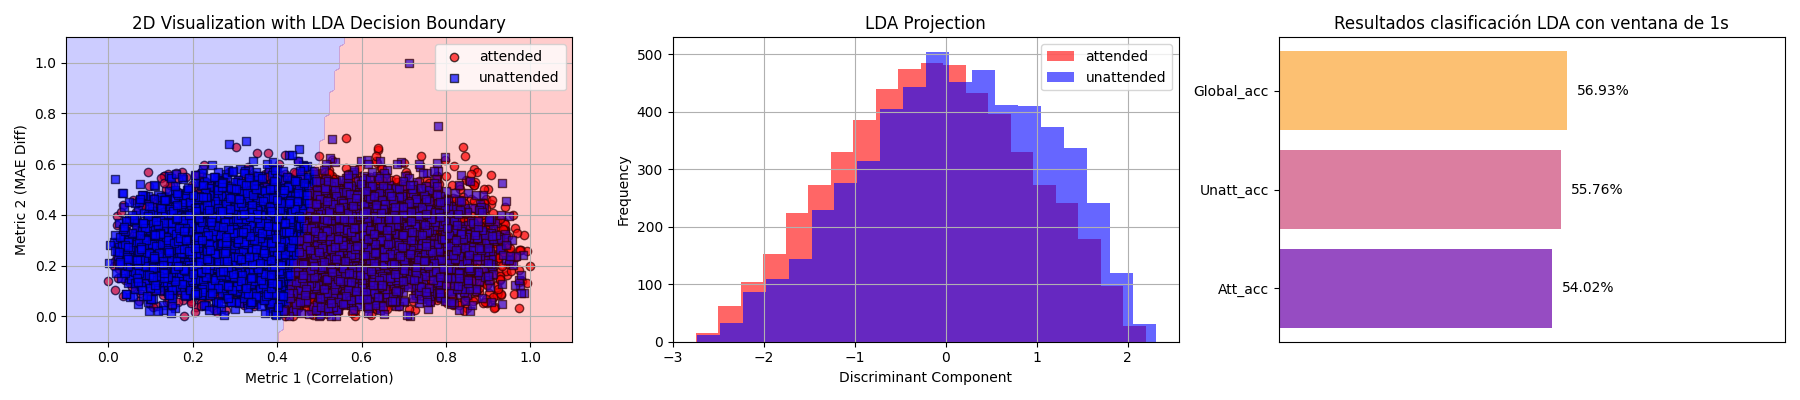

In [606]:
# Crear una figura con 3 gráficos en una fila
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# 1. Gráfico de puntos con frontera de decisión
for label, color, marker, class_label in zip([0, 1], ['red', 'blue'], ['o', 's'], ['attended', 'unattended']):
    axs[0].scatter(
        norm_metrics[labels == label, 0],
        norm_metrics[labels == label, 1],
        color=color,
        label=class_label,
        alpha=0.7,
        edgecolor='k',
        marker=marker
    )

# Calcular el espacio para la frontera de decisión
x_min, x_max = norm_metrics[:, 0].min() - 0.1, norm_metrics[:, 0].max() + 0.1
y_min, y_max = norm_metrics[:, 1].min() - 0.1, norm_metrics[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Generar predicciones para cada punto del grid
grid = np.c_[xx.ravel(), yy.ravel()]
decision_boundary = spatial_clsf.predict(grid)  # Usar el clasificador entrenado
decision_boundary = decision_boundary.reshape(xx.shape)

# Contorno de la frontera de decisión
axs[0].contourf(xx, yy, decision_boundary, levels=[-0.1, 0.5, 1.1], colors=['red', 'blue'], alpha=0.2)

# Configuración del gráfico
axs[0].set_title('2D Visualization with LDA Decision Boundary')
axs[0].set_xlabel('Metric 1 (Correlation)')
axs[0].set_ylabel('Metric 2 (MAE Diff)')
axs[0].legend()
axs[0].grid(True)

# 2. Histograma de la proyección LDA
for label, color, class_label in zip([0, 1], ['red', 'blue'], ['attended', 'unattended']):
    axs[1].hist(
        projected_data[labels == label],
        bins=20,
        alpha=0.6,
        color=color,
        label=class_label
    )
axs[1].set_title('LDA Projection')
axs[1].set_xlabel('Discriminant Component')
axs[1].set_ylabel('Frequency')
axs[1].legend()
axs[1].grid(True)

# 3. Gráfico de barras horizontal
colors = cm.plasma([0.2, 0.5, 0.8])
axs[2].barh(acc_labels, percentages, color=colors, alpha=0.7)
for i, valor in enumerate(percentages):
    axs[2].text(valor + 2, i, f'{valor:.2f}%', va='center', fontsize=10)
axs[2].set_title(f'LDA Accuracies')
axs[2].set_xlim(0, 100)
axs[2].grid(axis='x', linestyle='--', alpha=0.6)
axs[2].axes.get_xaxis().set_visible(False)

# Ajustar diseño
plt.tight_layout()
plt.title(f'Resultados clasificación LDA con ventana de {batch_size//64}s')
plt.show()
plt.savefig('./')

In [ ]:
p = []

In [655]:
window_accuracies = {1: 59, 2: 62, 5: 64, 10: 69, 25: 74, 50: 78}
# Introduce path to the mesd-toolbox
sys.path.append(r"C:\Users\jaulab\Desktop\AAD\mesd-toolbox\mesd-toolbox-python")
from mesd_toolbox import compute_MESD

In [657]:
# COMPUTE MESD (default values)
print('Computing MESD')
mesd_dict = {'mesd': None, 'N_mesd': None, 'tau_mesd': None, 'p_mesd': None}
tau = np.array(list(window_accuracies.keys()))
p = np.array([results / 100 for results in window_accuracies.values()])
if np.any(p > 0.5):
    mesd, N_mesd, tau_mesd, p_mesd = compute_MESD(tau,p)
    print(f"The minimal expected switch duration is MESD = {mesd} \nat an otpimal working point of (tau, p) = ({tau_mesd}, {p_mesd}) \nwith N = {N_mesd} states in the Markov chain.")
else:
    mesd, N_mesd, tau_mesd, p_mesd = 0, 0, 0, 0
    print(f"The MESD could not be computed")
mesd_results = [mesd, N_mesd, tau_mesd, p_mesd]
for idx, value in zip(list(mesd_dict.keys()), mesd_results):
    mesd_dict[idx] = value
# if wandb_upload: wandb.log(mesd_dict)

Computing MESD
The minimal expected switch duration is MESD = 20.270827160957133 
at an otpimal working point of (tau, p) = (1.147147147147147, 0.5944144144144143) 
with N = 10 states in the Markov chain.


In [658]:
mesd_dict

{'mesd': 20.270827160957133,
 'N_mesd': 10,
 'tau_mesd': 1.147147147147147,
 'p_mesd': 0.5944144144144143}